<function full_factorial_design at 0x7f9e16da7640>
4
6
8
10


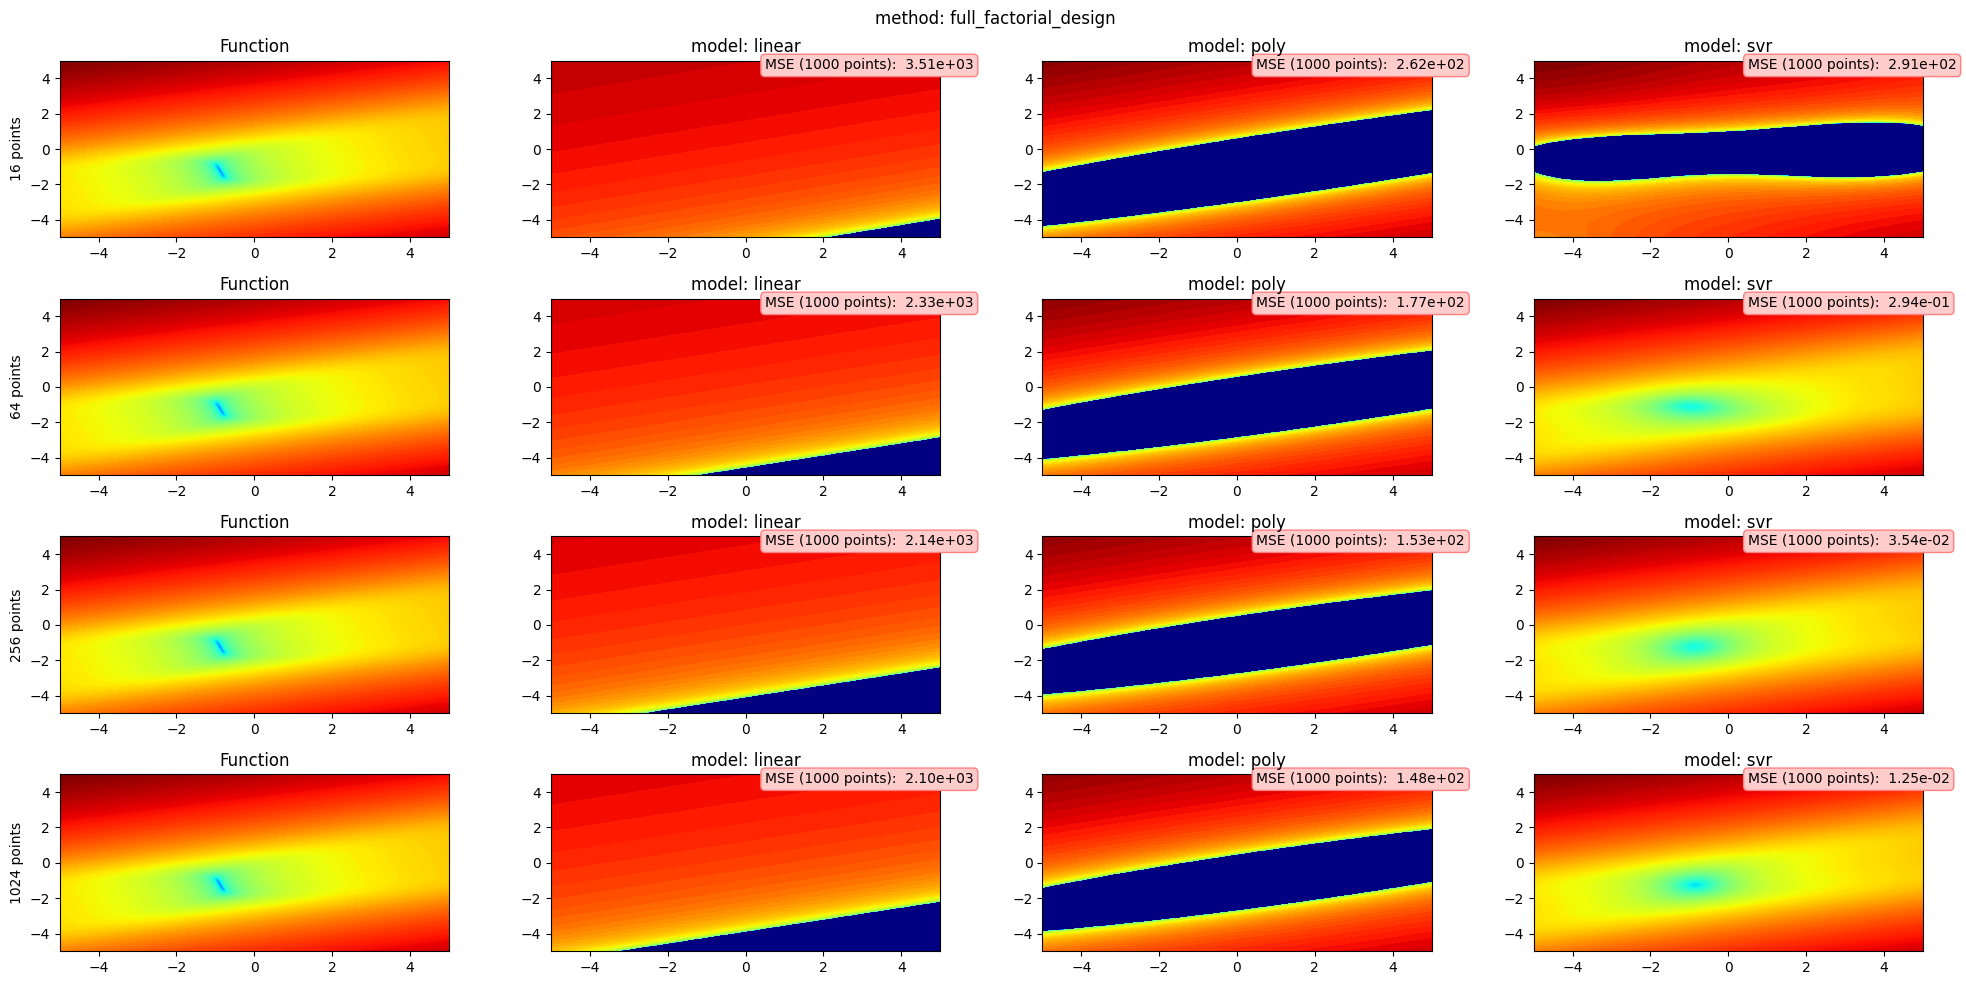

In [ ]:
import ioh 
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import qmc

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.base import clone
from pyDOE2 import fullfact 

models = (
    LinearRegression(), 
    Pipeline([
        ('features', PolynomialFeatures(2)), 
        ('lr', LinearRegression())
    ]),
    Pipeline([
        # ('scaler', StandardScaler()), 
        ('svr', SVR(C=10_000, epsilon=1e-4))
    ]),  
)
   
def get_meshgrid(objective_function, lb=-5, ub=5, delta: float = 0.025):
    x = np.arange(lb, ub + delta, delta)
    y = np.arange(lb, ub + delta, delta)
    X, Y = np.meshgrid(x, y)
    points = np.c_[X.ravel(), Y.ravel()]
    points_y = np.array(objective_function(points))
    Z = points_y.reshape(X.shape)
    return X, Y, Z


np.random.seed(12)

def random_points(dimension: int = 2, n: int = 64, lb: int = -5, ub: int = 5):
    return np.random.uniform(lb, ub, size=(dimension, n)).T

def sobol(dimension: int = 2, n: int = 64, lb: int = -5, ub: int = 5):
    base = qmc.Sobol(dimension, scramble=False).random(n)
    return qmc.scale(base, lb, ub)

def full_factorial_design(dimension: int = 2, n: int = 64, lb: int = -5, ub: int = 5):
    if (n & (n - 1)) != 0:
        raise ValueError("n must be a power of 2")
    
    factors = [2] * int(np.log2(n))
    
    levels = np.ones(dimension, dtype=int)
    
    for i in range(len(factors)):
        levels[i % dimension] *= 2    
    assert np.prod(levels) == n
    
    design = fullfact(levels)
    assert design.shape == (n, dimension), design.shape
    dm = design.max(axis=0)
    design = np.where(dm >0, design / dm, 0)
    return qmc.scale(design, lb, ub)
    
    
ms = (4, 6, 8, 10)
d = 2
fid = 14

function = ioh.get_problem(fid, 1, d)
test_set_x = random_points(d, n=1000)
test_set_y = function(test_set_x)
X_true, Y_true, Z_true = get_meshgrid(function)
Z_true = np.log10((Z_true - function.optimum.y).clip(1e-10, None))

for method in (
    random_points, 
    sobol, 
    full_factorial_design,
    ):
    print(method)
    f, all_ax = plt.subplots(len(ms), 4, figsize=(20, 10))
    f.suptitle(f"method: {method.__name__}")
    for j, m in enumerate(ms):
        print(m)
        n_points = pow(2, m)
        (ax1, *axes) = all_ax[j]
        ax1.contourf(
            X_true, Y_true, Z_true, levels=200, cmap="jet", zorder=-1, vmin=Z_true.min(), vmax=Z_true.max()
        )
        ax1.set_title("Function")
        ax1.set_ylabel(f"{n_points} points")

        point_set_x = method(d, n_points)
        point_set_y = function(point_set_x)


        for i, label in enumerate(("model: linear", "model: poly", "model: svr")):
            model = clone(models[i])
            model.fit(point_set_x, point_set_y)

            X, Y, Z = get_meshgrid(lambda x: model.predict(np.asarray(x)))
            Z = np.log10((Z - function.optimum.y).clip(1e-10, None))
            
            axes[i].contourf(
                X, Y, Z, levels=200, cmap="jet", zorder=-1, vmin=Z_true.min(), vmax=Z_true.max()
            )
            axes[i].set_title(label)
            y_pred = model.predict(test_set_x)
            mse = mean_squared_error(test_set_y, y_pred)
            axes[i].text(
                .5, 4.5,
                f"MSE (1000 points): {mse: .2e}",
                bbox=dict(
                    boxstyle="round",
                    ec=(1., 0.5, 0.5),
                    fc=(1., 0.8, 0.8),
                )
            )
    plt.tight_layout()

In [150]:
method = sobol
ms = (4, 6, 8, 10)
d = 2
fid = 14


data = []
for d in (2, 3, 5, 10):
    print(d)
    function = ioh.get_problem(fid, 1, d)
    test_set_x = random_points(d, n=d * 1000)
    test_set_y = function(test_set_x)

    for s, method in enumerate((random_points, sobol, full_factorial_design)):
        print(method)
        for j, m in enumerate(ms):
            print(m)
            n_points = pow(2, m)

            point_set_x = method(d, n_points)
            point_set_y = function(point_set_x)

            for i, label in enumerate(("model: linear", "model: poly", "model: svr")):
                model = clone(models[i])
                model.fit(point_set_x, point_set_y)
                y_pred = model.predict(test_set_x)
                mse = mean_squared_error(test_set_y, y_pred)
                data.append((d, n_points, i, s, mse))
                
                
                
                

2
<function random_points at 0x7f9e16da7a30>
4
6
8
10
<function sobol at 0x7f9e17706560>
4
6
8
10
<function full_factorial_design at 0x7f9e16da7640>
4
6
8
10
3
<function random_points at 0x7f9e16da7a30>
4
6
8
10
<function sobol at 0x7f9e17706560>
4
6
8
10
<function full_factorial_design at 0x7f9e16da7640>
4
6
8
10
5
<function random_points at 0x7f9e16da7a30>
4
6
8
10
<function sobol at 0x7f9e17706560>
4
6
8
10
<function full_factorial_design at 0x7f9e16da7640>
4
6
8


/tmp/ipykernel_85602/817726737.py:60: RuntimeWarning: invalid value encountered in divide
  design = np.where(dm >0, design / dm, 0)


10
10
<function random_points at 0x7f9e16da7a30>
4
6
8
10
<function sobol at 0x7f9e17706560>
4
6
8
10
<function full_factorial_design at 0x7f9e16da7640>
4
6
8


/tmp/ipykernel_85602/817726737.py:60: RuntimeWarning: invalid value encountered in divide
  design = np.where(dm >0, design / dm, 0)
/tmp/ipykernel_85602/817726737.py:60: RuntimeWarning: invalid value encountered in divide
  design = np.where(dm >0, design / dm, 0)
/tmp/ipykernel_85602/817726737.py:60: RuntimeWarning: invalid value encountered in divide
  design = np.where(dm >0, design / dm, 0)


10


In [151]:
import pandas as pd
df = pd.DataFrame(data, columns=["d", "n", "method", "sampler", "mse"])

# df[(df.method == 0) & (df.d == 2)]
# df['sampler'] = np.tile(np.repeat([0, 1], 3 * 4), 4)

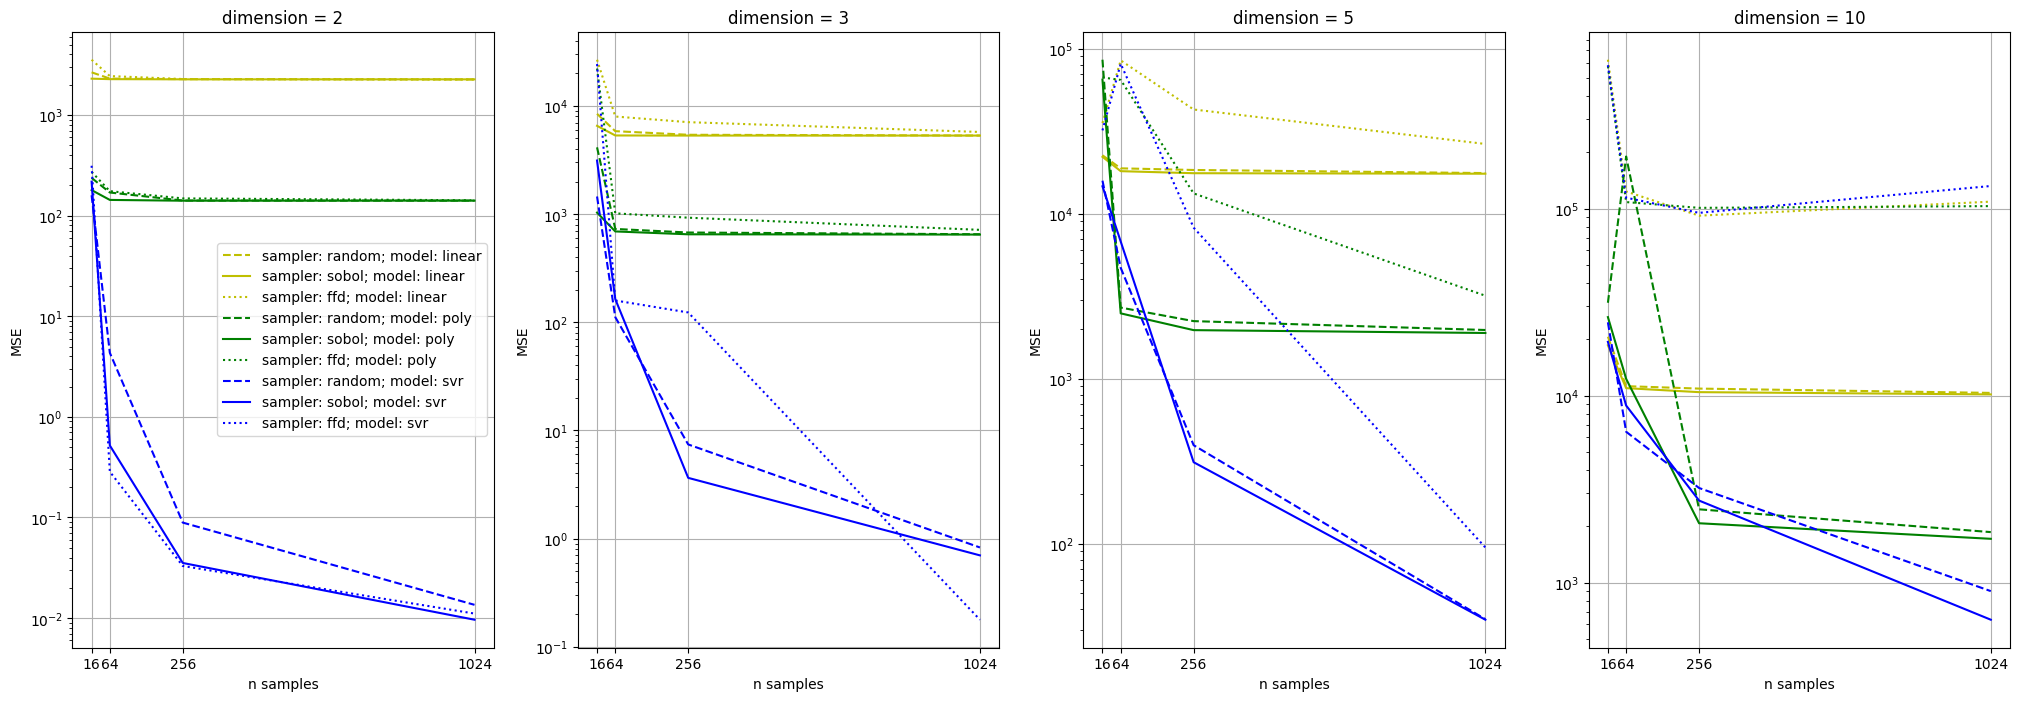

In [154]:
f, axes = plt.subplots(1, 4, figsize=(25, 8))
for d , ax in zip([2, 3, 5, 10], axes.ravel()):
    
    for label, group in df.query(f"d == {d}").groupby(["method", "sampler"]):
        ltext = "sampler: "
        ltext += ("random; ", 'sobol; ', 'ffd; ')[label[1]]
        ltext += ("model: linear", "model: poly", "model: svr")[label[0]]
        linestyle = ('dashed', "solid", "dotted")[label[1]]
        color = 'ygb'[label[0]]
        ax.plot(group['n'], group['mse'], label=ltext, color=color, linestyle=linestyle)
        
    ax.set_title(f"dimension = {d}")
        
    ax.set_xticks(group['n']) 
    ax.set_xlabel("n samples")
    ax.set_ylabel("MSE")
    ax.set_yscale("log")
    ax.grid()
    if d == 2:
        ax.legend()

In [ ]:




full_factorial_design(n=128)
    
    

array([[-5.        , -5.        ],
       [-4.33333333, -5.        ],
       [-3.66666667, -5.        ],
       [-3.        , -5.        ],
       [-2.33333333, -5.        ],
       [-1.66666667, -5.        ],
       [-1.        , -5.        ],
       [-0.33333333, -5.        ],
       [ 0.33333333, -5.        ],
       [ 1.        , -5.        ],
       [ 1.66666667, -5.        ],
       [ 2.33333333, -5.        ],
       [ 3.        , -5.        ],
       [ 3.66666667, -5.        ],
       [ 4.33333333, -5.        ],
       [ 5.        , -5.        ],
       [-5.        , -3.57142857],
       [-4.33333333, -3.57142857],
       [-3.66666667, -3.57142857],
       [-3.        , -3.57142857],
       [-2.33333333, -3.57142857],
       [-1.66666667, -3.57142857],
       [-1.        , -3.57142857],
       [-0.33333333, -3.57142857],
       [ 0.33333333, -3.57142857],
       [ 1.        , -3.57142857],
       [ 1.66666667, -3.57142857],
       [ 2.33333333, -3.57142857],
       [ 3.        ,

In [ ]:
def find_levels(n, f):
    # Ensure n is a power of 2
   

find_levels(16 * 2, 3)

array([4., 4., 2.])